# Mind the gap: investigation of income and wealth inequality

Data sources: 
- [World Inequality Database](https://wid.world/) 
- [World Bank Open Data](https://data.worldbank.org/)
- [OECD Data](https://data.oecd.org/)

__Sections__
- [World](#world)
- [Countries](#countries)
- [OECD](#oecd)
- [Top 10 GDP countries](#gdp)
- [G7](#g7)

***

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
import seaborn as sns

## Import data

### World Inequality Database

In [2]:
w = pd.read_csv('../data/raw/WID_Data_w.csv', sep=';', skiprows=1).drop(['Percentile','Year'], axis=1)
region_col = w.columns.str.replace('.*\n.*\n.*\n','', regex=True)
# columns for regions
region_col

Index(['Africa', 'Americas', 'Asia', 'Asia (excl. Middle East)',
       'Australia and New Zealand', 'Caribbean', 'Central America',
       'Central Asia', 'East Africa', 'East Asia', 'Eastern Europe', 'Europe',
       'European Union', 'Latin America', 'MENA', 'Middle Africa',
       'Middle East', 'North Africa', 'North America',
       'North America & Oceania', 'Oceania',
       'Oceania (excl. Australia and New Zealand)', 'Other East Asia',
       'Other Latin America', 'Other MENA', 'Other North America & Oceania',
       'Other Russia & Central Asia', 'Other South & South-East Asia',
       'Other Sub-Saharan Africa', 'Other Western Europe',
       'Russia & Central Asia', 'South Africa', 'South America', 'South Asia',
       'South-East Asia', 'South & South-East Asia', 'Sub-Saharan Africa',
       'West Africa', 'West Asia', 'Western Europe', 'World'],
      dtype='object')

In [3]:
def prepdata(filename:str, value_name:str, text='.*\n.*\n.*\n')->pd.DataFrame:
    
    '''For file from World Inequality Database, ,load file from file name, remove text from col name, 
    remove market value col, melt and set value col name'''
    
    path = '../data/raw/' + filename + '.csv' 
    df = pd.read_csv(path, sep=';', skiprows=1).drop(['Percentile'], axis=1)
    df.columns = df.columns.str.replace(text,'', regex=True)
    df_col = df.columns[~df.columns.str.contains('Year|at market', regex=True)]
    df = df.melt(id_vars=['Year'], value_vars=df_col, var_name='country', value_name=value_name)
    return df

# Income

In [4]:
# Equal-split pre-tax mean income
pretax_mean_income = prepdata('WID_Data_pretax_mean_income', 'pretax_mean_income')

In [5]:
# Equal-split post-tax mean income
posttax_mean_income = prepdata('WID_Data_posttax_mean_income', 'posttax_mean_income')

In [6]:
# Equal-split pre-tax median income
pretax_median_income = prepdata('WID_Data_pretax_median_income', 'pretax_median_income')

In [7]:
# Equal-split post-tax median income
posttax_median_income = prepdata('WID_Data_posttax_median_income', 'posttax_median_income')

In [8]:
# Equal-split pre-tax gini income
pretax_gini_income = prepdata('WID_Data_pretax_gini_income', 'pretax_gini_income')

In [9]:
# Equal-split post-tax gini income
posttax_gini_income = prepdata('WID_Data_posttax_gini_income', 'posttax_gini_income')

# Wealth

In [10]:
# Equal-split mean wealth
mean_wealth = prepdata('WID_Data_mean_wealth', 'mean_wealth')

In [11]:
# Equal-split median wealth
median_wealth = prepdata('WID_Data_median_wealth', 'median_wealth')

In [12]:
# Equal-split gini wealth
gini_wealth = prepdata('WID_Data_gini_wealth', 'gini_wealth')

# Trade

In [13]:
trade = pd.read_csv('../data/raw/GDP_trade.csv', skiprows=4)
trade = trade.rename(columns={'Country Name':'country'}).\
drop(['Country Code', 'Indicator Name', 'Indicator Code', 'Unnamed: 67'], axis=1)
trade = trade.melt(id_vars='country',var_name='Year', value_name='trade')
trade.Year = trade.Year.astype('int64')
trade.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16758 entries, 0 to 16757
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   country  16758 non-null  object 
 1   Year     16758 non-null  int64  
 2   trade    10693 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 392.9+ KB


# Merge Data

In [14]:
data = pretax_mean_income.merge(posttax_mean_income, how='outer', on=['Year', 'country']).\
merge(pretax_median_income, how='outer',on=['Year', 'country']).\
merge(posttax_median_income, how='outer',on=['Year', 'country']).\
merge(pretax_gini_income, how='outer',on=['Year', 'country']).\
merge(posttax_gini_income, how='outer',on=['Year', 'country']).\
merge(mean_wealth, how='outer', on=['Year', 'country']).\
merge(median_wealth, how='outer',on=['Year', 'country']).\
merge(gini_wealth, how='outer',on=['Year', 'country']).\
merge(trade, how='left', on=['Year', 'country'])

In [15]:
# Add mean/median ratio
data['pretax_income_mean_median_ratio'] = data.pretax_mean_income/data.pretax_median_income
data['posttax_income_mean_median_ratio'] = data.posttax_mean_income/data.posttax_median_income
data['wealth_mean_median_ratio'] = data.mean_wealth/data.median_wealth
# Add post/pre raio
data['mean_posttax_pretax_income_ratio'] = data.posttax_mean_income/data.pretax_mean_income
data['median_posttax_pretax_income_ratio'] = data.posttax_median_income/data.pretax_median_income
data['posttax_pretax_gini_income_ratio'] = data.posttax_gini_income/data.pretax_gini_income

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19521 entries, 0 to 19520
Data columns (total 18 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Year                                19521 non-null  int64  
 1   country                             19521 non-null  object 
 2   pretax_mean_income                  19482 non-null  float64
 3   posttax_mean_income                 19381 non-null  float64
 4   pretax_median_income                19482 non-null  float64
 5   posttax_median_income               19381 non-null  float64
 6   pretax_gini_income                  19482 non-null  float64
 7   posttax_gini_income                 4229 non-null   float64
 8   mean_wealth                         19350 non-null  float64
 9   median_wealth                       19350 non-null  float64
 10  gini_wealth                         19377 non-null  float64
 11  trade                               17640

In [17]:
data.describe()

Year  pretax_mean_income  posttax_mean_income  \
count  19521.00000        19482.000000         19381.000000   
mean    2008.00000        23300.292392         23487.012648   
std        7.78908        14389.582050         14081.580023   
min     1995.00000          218.214700           218.214700   
25%     2001.00000        19617.287600         19932.696800   
50%     2008.00000        22224.651700         22373.432600   
75%     2015.00000        23894.799600         24135.195600   
max     2021.00000       226775.326700        226775.326700   

       pretax_median_income  posttax_median_income  pretax_gini_income  \
count          19482.000000           19381.000000        19482.000000   
mean            9756.873312           11541.082788            0.664178   
std            10431.293369           10646.185559            0.081876   
min              134.202100             157.366900            0.307445   
25%             5906.070225            8409.882200            0.628780   
50%             7439.465400            9578.430400            0.677105   
75%             8312.376000           10206.545600            0.746030   
max           164195.716000          184439.023400            0.781373   

       posttax_gini_income    mean_wealth  median_wealth   gini_wealth  \
count          4229.000000   19350.000000   19350.000000  19377.000000   
mean              0.536945   57573.139181    9250.032691      0.906384   
std               0.108025   53566.389295   20467.910490      0.091320   
min               0.025816  -54433.168400  -12778.500500      0.539493   
25%               0.469518   40086.535100    3270.232900      0.860445   
50%               0.594295   56028.543300    4101.391200      0.936640   
75%               0.602156   62813.822000    5204.359200      0.964393   
max               0.744154  632472.971000  227873.105500      1.059585   

              trade  pretax_income_mean_median_ratio  \
count  17640.000000                     19482.000000   
mean      58.214404                         2.802476   
std       27.622412                         0.846508   
min        0.020999                         0.892857   
25%       46.220722                         2.210913   
50%       53.768141                         2.737154   
75%       57.125139                         3.757342   
max      437.326715                         4.545455   

       posttax_income_mean_median_ratio  wealth_mean_median_ratio  \
count                      19381.000000              19350.000000   
mean                           2.235873                 10.819813   
std                            0.455841                  4.847632   
min                            0.998409                  1.418440   
25%                            1.955979                  5.405406   
50%                            2.254333                 12.500000   
75%                            2.669591                 14.285714   
max                            3.695096                 17.904947   

       mean_posttax_pretax_income_ratio  median_posttax_pretax_income_ratio  \
count                      19381.000000                        19381.000000   
mean                           1.011954                            1.247749   
std                            0.045407                            0.162887   
min                            0.618250                            0.333333   
25%                            1.000000                            1.101693   
50%                            1.000000                            1.248565   
75%                            1.026884                            1.390728   
max                            2.347907                            2.686837   

       posttax_pretax_gini_income_ratio  
count                       4229.000000  
mean                           0.837564  
std                            0.098870  
min                            0.065316  
25%                            0.796328  
50%                  

In [18]:
cor=data.loc[(~data.country.isin(region_col))].query('Year==2021').drop(['Year','country'], axis=1).corr('kendall')

Check correlation

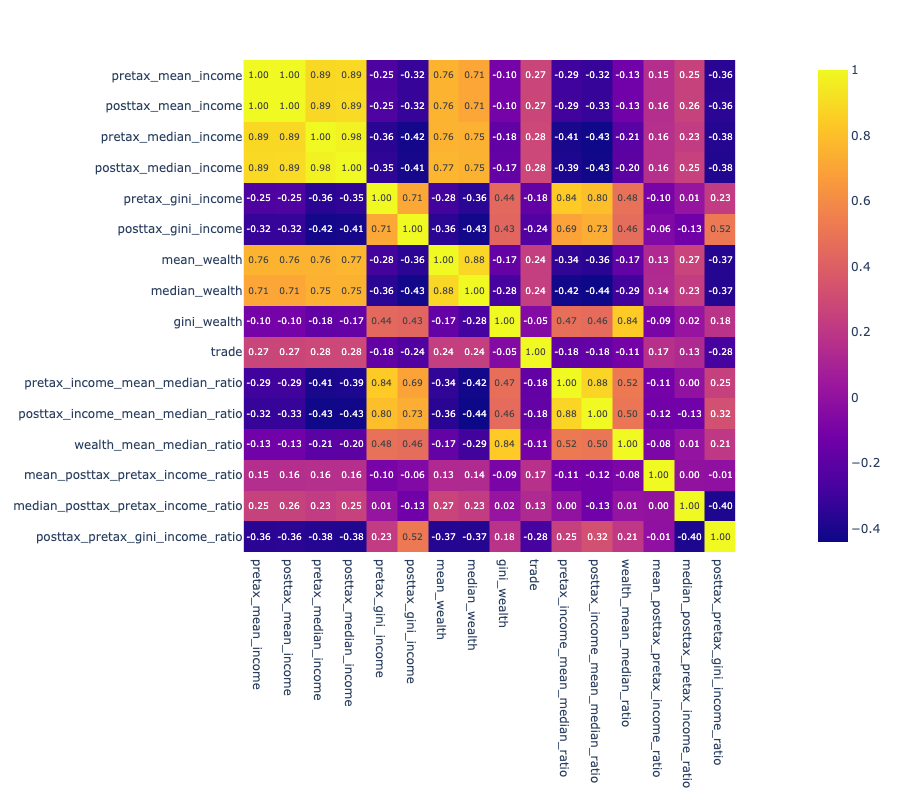

In [19]:
fig = px.imshow(cor, text_auto='.2f' , width=900, height=800)
fig.show('png')

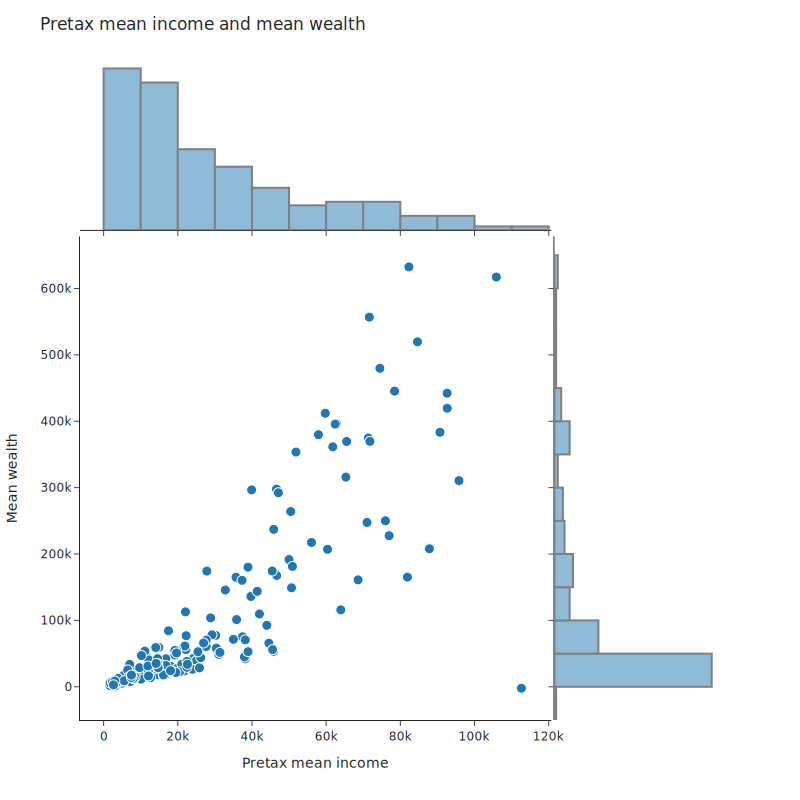

In [20]:
fig = px.scatter(data.loc[(~data.country.isin(region_col))].query('Year==2021'), x="pretax_mean_income", 
                 y="mean_wealth", hover_name="country", marginal_x='histogram', marginal_y='histogram', 
                template='simple_white', width=800, height=800)
fig.update_layout(showlegend=False, yaxis_title='Mean wealth',xaxis_title='Pretax mean income', 
                  title='Pretax mean income and mean wealth')
fig.update_traces(marker=dict(size=10,line=dict(width=1, color='white')), selector=dict(type='scatter'))
fig.update_traces(marker=dict(line=dict(width=2,color='black')), selector=dict(type='histogram'))

fig.show('svg')

Wealth and income have strong correlation as expected.

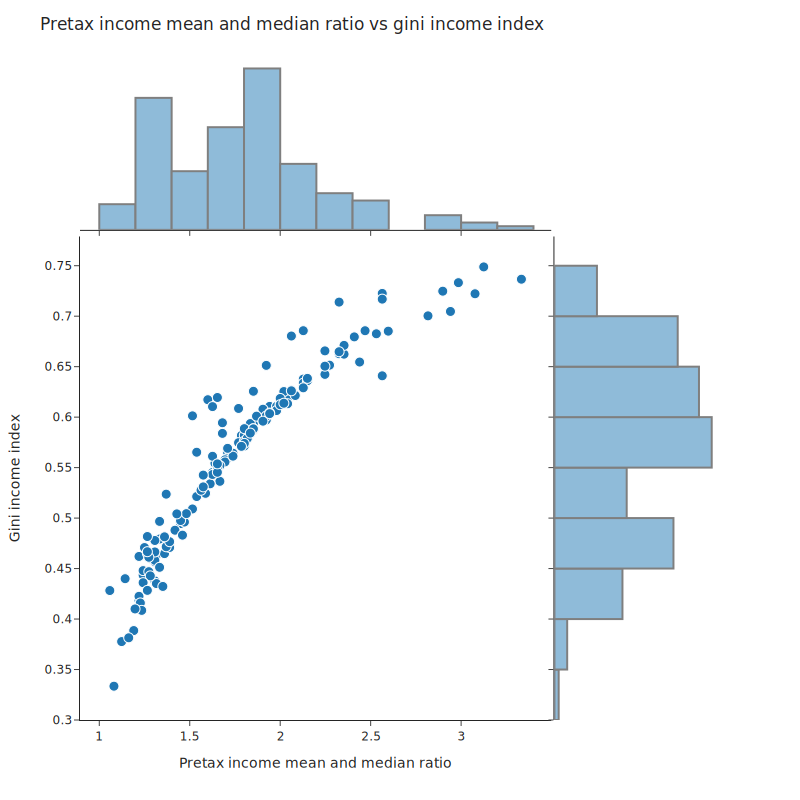

In [191]:
fig = px.scatter(data.loc[(~data.country.isin(region_col))].query('Year==2021'), x="pretax_income_mean_median_ratio", 
                 y="pretax_gini_income", hover_name="country", marginal_x='histogram', marginal_y='histogram', 
                template='simple_white', width=800, height=800)
fig.update_layout(showlegend=False, yaxis_title='Gini income index',xaxis_title='Pretax income mean and median ratio',
                 title='Pretax income mean and median ratio vs gini income index')
fig.update_traces(marker=dict(size=10,line=dict(width=1, color='white')), selector=dict(type='scatter'))
fig.update_traces(marker=dict(line=dict(width=2,color='black')), selector=dict(type='histogram'))

fig.show('svg')

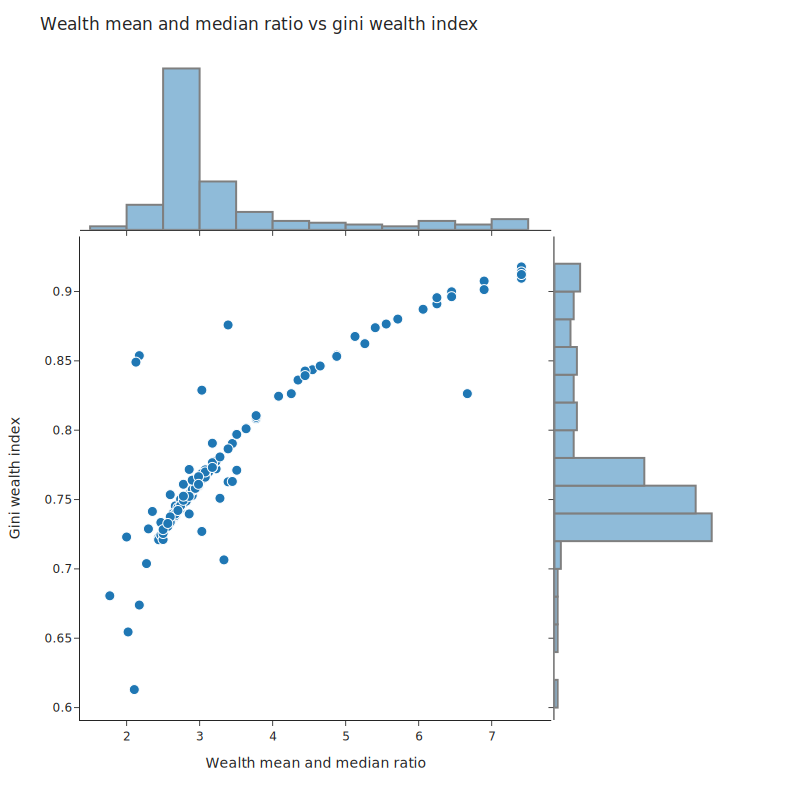

In [21]:
fig = px.scatter(data.loc[(~data.country.isin(region_col))].query('Year==2021'), x="wealth_mean_median_ratio", 
                 y="gini_wealth", hover_name="country", marginal_x='histogram', marginal_y='histogram', 
                template='simple_white', width=800, height=800)
fig.update_layout(showlegend=False, yaxis_title='Gini wealth index',xaxis_title='Wealth mean and median ratio',
                 title='Wealth mean and median ratio vs gini wealth index')
fig.update_traces(marker=dict(size=10,line=dict(width=1, color='white')), selector=dict(type='scatter'))
fig.update_traces(marker=dict(line=dict(width=2,color='black')), selector=dict(type='histogram'))

fig.show('svg')

Mean and median ratio also have strong correlation with gini index.

***

# World<a id='world'><a>

In [22]:
world = data.loc[data.country=='World']

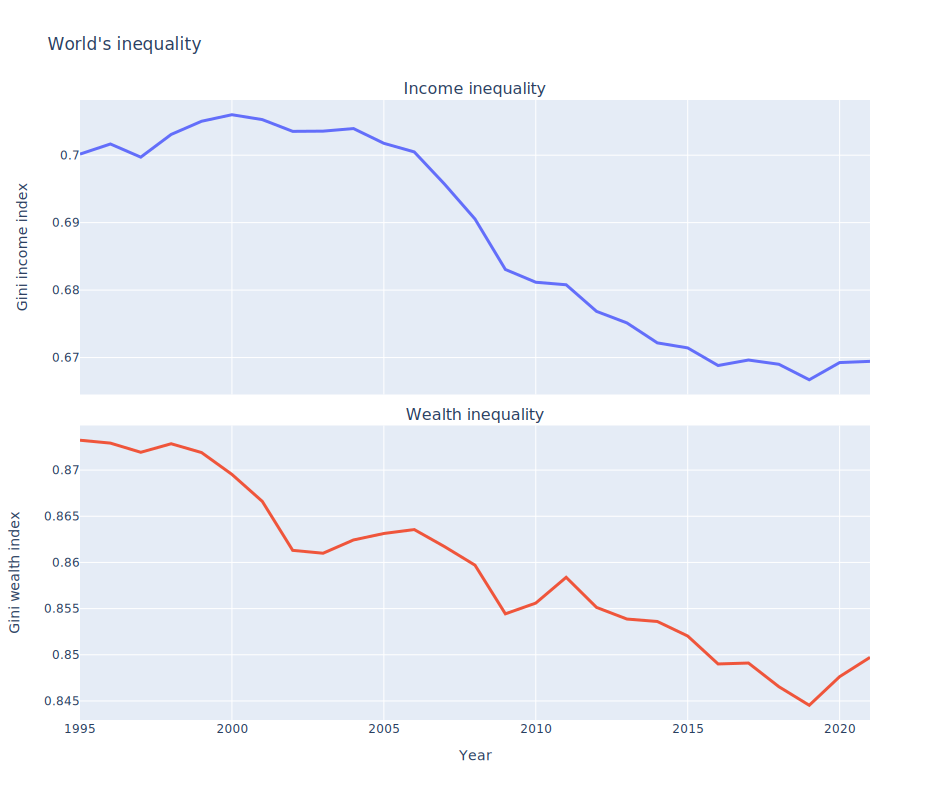

In [23]:
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, subplot_titles=("Income inequality", "Wealth inequality"), 
                    vertical_spacing=0.05)

fig.append_trace(go.Scatter(x=world.Year, y=world.pretax_gini_income, mode='lines', line={'width':3}), row=1, col=1)
fig.update_yaxes(title_text="Gini income index", row=1, col=1)

fig.add_trace(go.Scatter(x=world.Year, y=world.gini_wealth, mode='lines', line={'width':3}), row=2, col=1)
fig.update_xaxes(title_text="Year", row=2, col=1)
fig.update_yaxes(title_text="Gini wealth index", row=2, col=1)

fig.update_layout(showlegend=False,
                  template='plotly',
                  width=950, height=800,
                  title=dict(text="World's inequality"))
fig.show('svg')

Income and wealth between countries are decreasing.

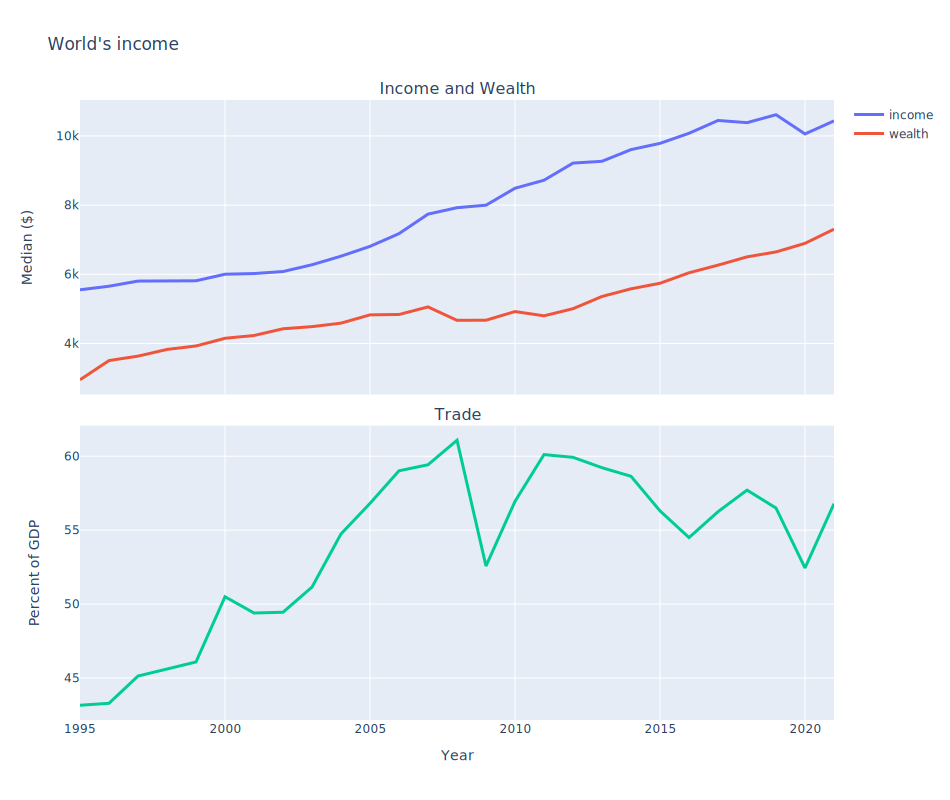

In [24]:
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, subplot_titles=("Income and Wealth","Trade"),
                   vertical_spacing=0.05)

fig.append_trace(go.Scatter(x=world.Year, y=world.pretax_median_income, name='income', mode='lines', 
                            line={'width':3}), row=1, col=1)
fig.append_trace(go.Scatter(x=world.Year, y=world.median_wealth, name='wealth', mode='lines', 
                            line={'width':3}), row=1, col=1)
fig.update_yaxes(title_text="Median ($)", row=1, col=1)

fig.add_trace(go.Scatter(x=world.Year, y=world.trade, mode='lines', line={'width':3}, showlegend=False), row=2, col=1)
fig.update_xaxes(title_text="Year", row=2, col=1)
fig.update_yaxes(title_text="Percent of GDP", row=2, col=1)

fig.update_layout(showlegend=True,
                  template='plotly',
                  width=950, height=800,
                  title=dict(text="World's income"))
fig.show('svg')

Median of income and wealth of each country are getting higher because trade globalization.

***

# Countries<a id='countries'><a>

In [51]:
countries = data.loc[(~data.country.isin(region_col))]

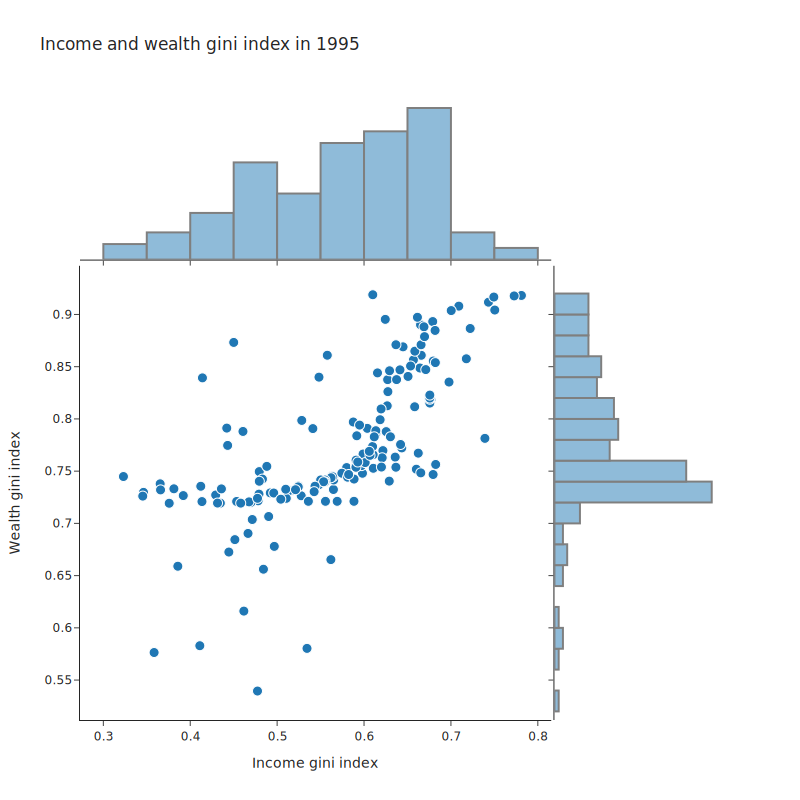

In [52]:
fig = px.scatter(countries.query('Year==1995'), x="pretax_gini_income", y="gini_wealth", hover_name="country",
                 title='Income and wealth gini index in 1995', marginal_x='histogram', marginal_y='histogram', 
                template='simple_white', width=800, height=800)
fig.update_layout(showlegend=False, yaxis_title='Wealth gini index',xaxis_title='Income gini index')
fig.update_traces(marker=dict(size=10,line=dict(width=1, color='white')),selector=dict(type='scatter'))
fig.update_traces(marker=dict(line=dict(width=2,color='black')), selector=dict(type='histogram'))
fig.show('svg')

In [207]:
print(f'1995 gini income: {countries.query("Year==1995").pretax_gini_income.mean()}, gini wealth: {countries.query("Year==1995").gini_wealth.mean()}')

1995 gini income: 0.5724298093688757, gini wealth: 0.776550940266341


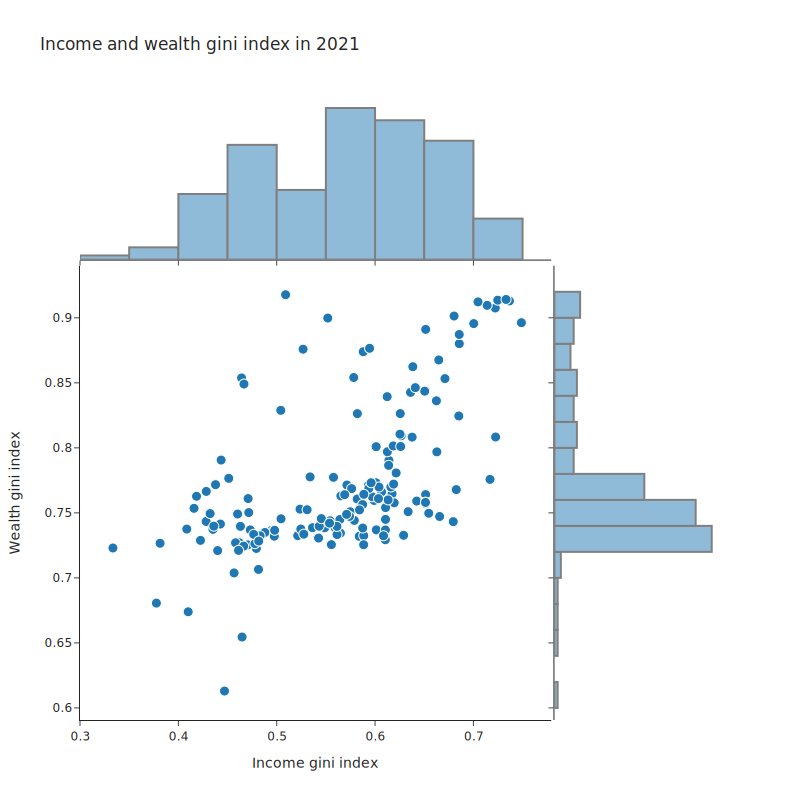

In [53]:
fig = px.scatter(countries.query('Year==2021'), x="pretax_gini_income", y="gini_wealth", hover_name="country",
                 title='Income and wealth gini index in 2021', marginal_x='histogram', marginal_y='histogram', 
                template='simple_white', width=800, height=800)
fig.update_layout(showlegend=False, yaxis_title='Wealth gini index',xaxis_title='Income gini index')
fig.update_traces(marker=dict(size=10,line=dict(width=1, color='white')),selector=dict(type='scatter'))
fig.update_traces(marker=dict(line=dict(width=2,color='black')), selector=dict(type='histogram'))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show('svg')

In [208]:
print(f'1995 gini income: {countries.query("Year==2021").pretax_gini_income.mean()}, gini wealth: {countries.query("Year==2021").gini_wealth.mean()}')

1995 gini income: 0.5678619338316686, gini wealth: 0.7721907405577151


Income and wealth inequality within country are pretty much the same.

***

# OECD<a id='oecd'><a>

In [25]:
oecd_members = np.array([
    'Australia', 'Austria', 'Belgium', 'Canada', 'Chile', 'Czech Republic', 'Denmark',
    'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Iceland', 'Ireland',
    'Israel', 'Italy', 'Japan', 'Korea', 'Latvia', 'Lithuania', 'Luxembourg', 'Mexico',
    'Netherlands', 'New Zealand', 'Norway', 'Poland', 'Portugal', 'Slovak Republic', 'Slovenia',
    'Spain', 'Sweden', 'Switzerland', 'Turkey', 'United Kingdom', 'USA'
])

In [26]:
oecd = data.loc[(data.country.isin(oecd_members))]

In [27]:
fig = px.scatter(oecd, x="pretax_gini_income", y="gini_wealth", animation_frame="Year", size='pretax_mean_income'
                 , hover_name="country", text='country',title='Wealth and Income inequality'
                ,color="country", range_x=[0.3, 0.8], range_y=[0.6, 0.95])
fig.update_layout(showlegend=False, yaxis_title='Wealth gini',xaxis_title='Income gini')
fig.update_traces(textposition='top center', textfont_size=9, selector=dict(type='scatter'))
fig.show()

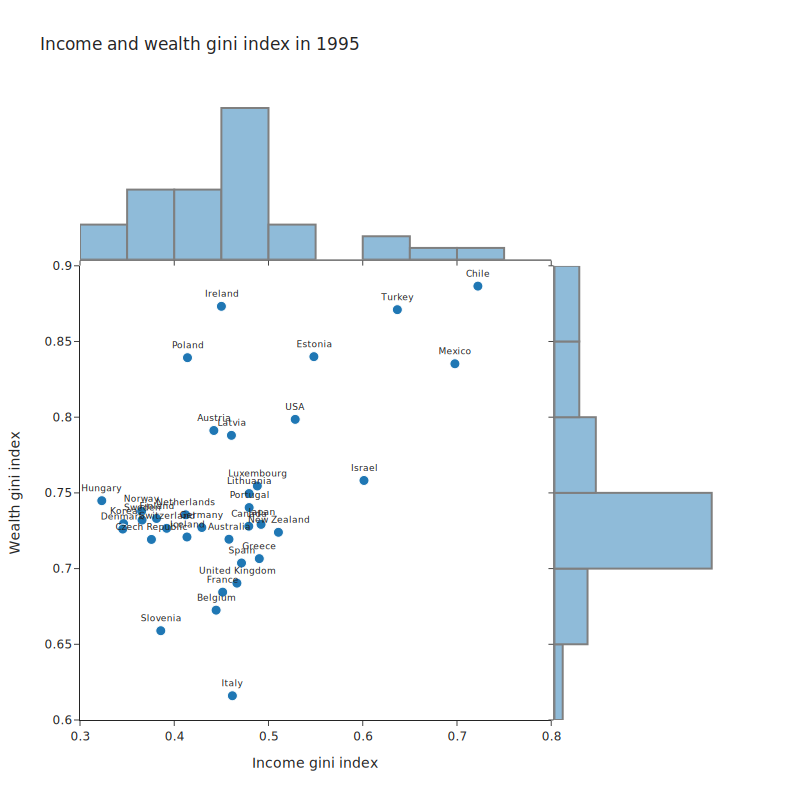

In [28]:
fig = px.scatter(oecd.query('Year==1995'), x="pretax_gini_income", y="gini_wealth", hover_name="country", text='country',
                 title='Income and wealth gini index in 1995', marginal_x='histogram', marginal_y='histogram', 
                template='simple_white', width=800, height=800, range_x=[0.3, 0.8],range_y=[0.6,0.9])
fig.update_layout(showlegend=False, yaxis_title='Wealth gini index',xaxis_title='Income gini index')
fig.update_traces(marker=dict(size=10,line=dict(width=1, color='white')), textposition='top center', textfont_size=9,selector=dict(type='scatter'))
fig.update_traces(marker=dict(line=dict(width=2,color='black')), selector=dict(type='histogram'))
fig.show('svg')

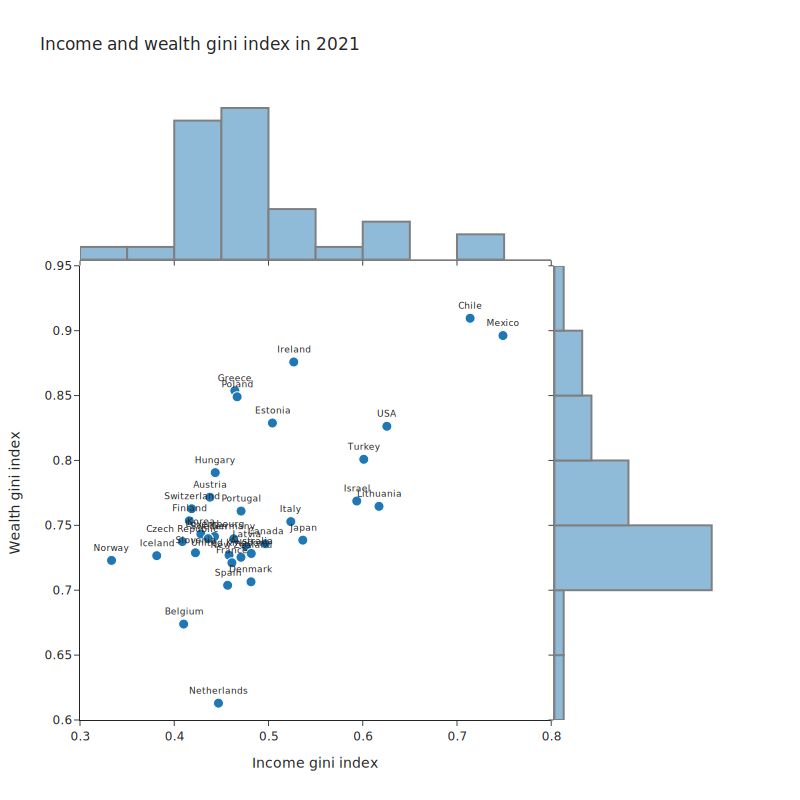

In [29]:
fig = px.scatter(oecd.query('Year==2021'), x="pretax_gini_income", y="gini_wealth", hover_name="country", text='country',
                 title='Income and wealth gini index in 2021', marginal_x='histogram', marginal_y='histogram', 
                template='simple_white', width=800, height=800, range_x=[0.3, 0.8],range_y=[0.6,0.95])
fig.update_layout(showlegend=False, yaxis_title='Wealth gini index',xaxis_title='Income gini index')
fig.update_traces(marker=dict(size=10,line=dict(width=1, color='white')), textposition='top center', textfont_size=9,selector=dict(type='scatter'))
fig.update_traces(marker=dict(line=dict(width=2,color='black')), selector=dict(type='histogram'))
fig.show('svg')

In [30]:
oecd_wealth_gini = oecd.loc[(oecd.Year==1995) | (oecd.Year==2021), ['Year', 'country','gini_wealth']]
oecd_wealth_gini = oecd_wealth_gini.pivot(index='country', columns='Year').reset_index()
oecd_wealth_gini['change'] = oecd_wealth_gini.gini_wealth[2021]-oecd_wealth_gini.gini_wealth[1995]

In [31]:
#use pretax because posttax data is incomplete
oecd_pretax_gini = oecd.loc[(oecd.Year==1995) | (oecd.Year==2021), ['Year', 'country','pretax_gini_income']]
oecd_pretax_gini = oecd_pretax_gini.pivot(index='country', columns='Year').reset_index()
oecd_pretax_gini['change'] = oecd_pretax_gini.pretax_gini_income[2021]-oecd_pretax_gini.pretax_gini_income[1995]

In [32]:
def plot_arrow(df, col_sort, col_start, col_end, col_y):
#sort individuals by amount of change, from largest to smallest
    data = df.sort_values([col_sort])

#initialize a plot
    plt.figure(figsize=(5,10))

#add start points
    sns.stripplot(data=data, 
                   x=col_start, 
                   y=col_y, 
                   orient='h', 
                   order=data[col_y], 
                   size=5, 
                   color='black')

#define arrows
    arrow_starts = data[col_start].values
    arrow_lengths = data[col_end].values - arrow_starts

#add arrows to plot
    for i, country in enumerate(data[col_y]):
        if arrow_lengths[i] > 0:
            arrow_color = 'red'
        else:
            arrow_color = 'green'
        plt.arrow(arrow_starts[i],        #x start point
             i,                      #y start point
             arrow_lengths[i],       #change in x 
             0,                      #change in y
             head_width=0.4,         #arrow head width
             head_length=0.01,        #arrow head length
             width=0.1,              #arrow stem width
             fc=arrow_color,             #arrow fill color
             ec=arrow_color)             #arrow edge color

In [33]:
def plot_arrow_change(df, col_sort, col_start, col_end, col_y, figsize=(5,10)):
#sort individuals by amount of change, from largest to smallest
    data = df.sort_values([col_sort])

#initialize a plot
    plt.figure(figsize=figsize)

#add start points
    sns.stripplot(data=data, 
                   x=col_sort, 
                   y=col_y, 
                   orient='h', 
                   order=data[col_y], 
                   size=0, 
                   color='black')

#define arrows
    arrow_starts = data[col_start].values
    arrow_starts_2 = np.repeat(0, data.shape[0])
    arrow_lengths = data[col_end].values - arrow_starts

#add arrows to plot
    for i, country in enumerate(data[col_y]):
        if arrow_lengths[i] > 0:
            arrow_color = 'red'
        else:
            arrow_color = 'green'
        plt.arrow(arrow_starts_2[i],        #x start point
             i,                      #y start point
             arrow_lengths[i],       #change in x 
             0,                      #change in y
             head_width=0.4,         #arrow head width
             head_length=0.01,        #arrow head length
             width=0.1,              #arrow stem width
             fc=arrow_color,             #arrow fill color
             ec=arrow_color)             #arrow edge color
    plt.axvline(x=0, ls='--', lw=2, c='k')

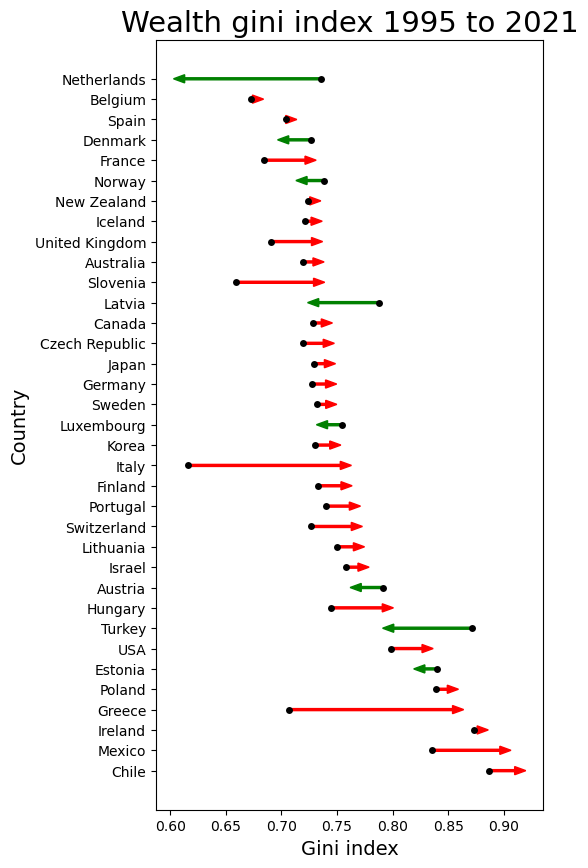

In [34]:
plot_arrow(oecd_wealth_gini, ('gini_wealth', 2021), ('gini_wealth', 1995), ('gini_wealth', 2021), 'country')
plt.title('Wealth gini index 1995 to 2021', fontsize=21)
plt.xlabel('Gini index', fontsize=14) 
plt.ylabel('Country', fontsize=14) 
plt.show()

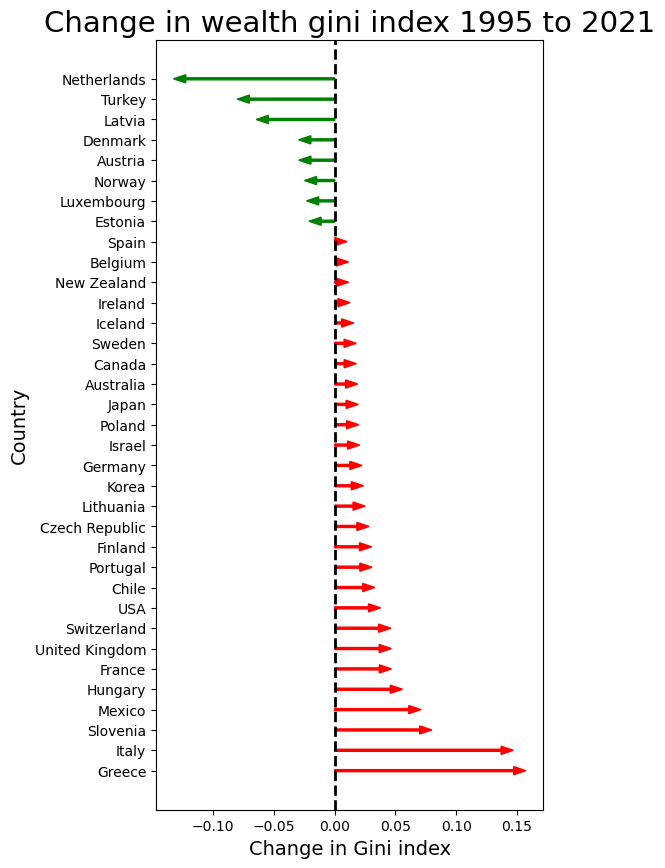

In [35]:
plot_arrow_change(oecd_wealth_gini, 'change', ('gini_wealth', 1995), ('gini_wealth', 2021), 'country')
plt.title('Change in wealth gini index 1995 to 2021', fontsize=21)
plt.xlabel('Change in Gini index', fontsize=14) 
plt.ylabel('Country', fontsize=14) 
plt.show()

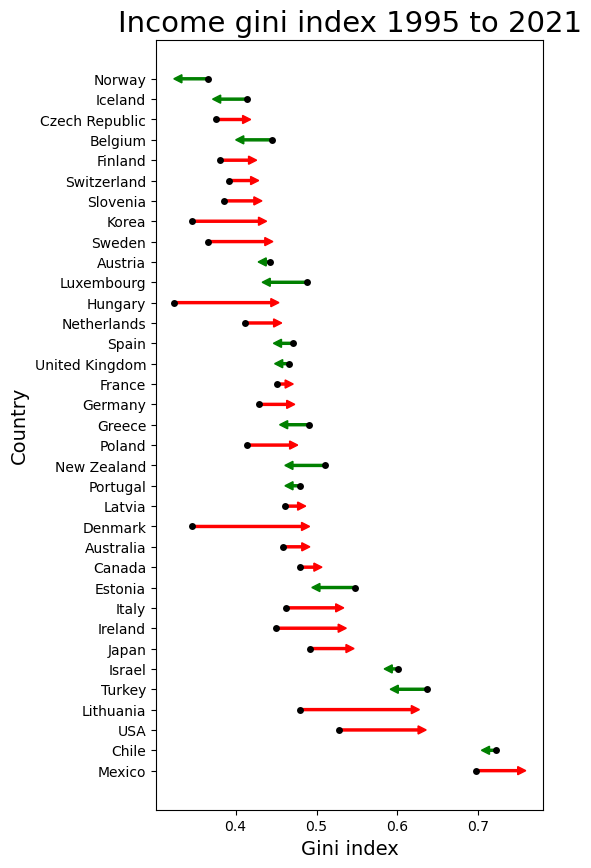

In [36]:
plot_arrow(oecd_pretax_gini, ('pretax_gini_income', 2021), ('pretax_gini_income', 1995), ('pretax_gini_income', 2021), 'country')
plt.title('Income gini index 1995 to 2021', fontsize=21)
plt.xlabel('Gini index', fontsize=14) 
plt.ylabel('Country', fontsize=14) 
plt.show()

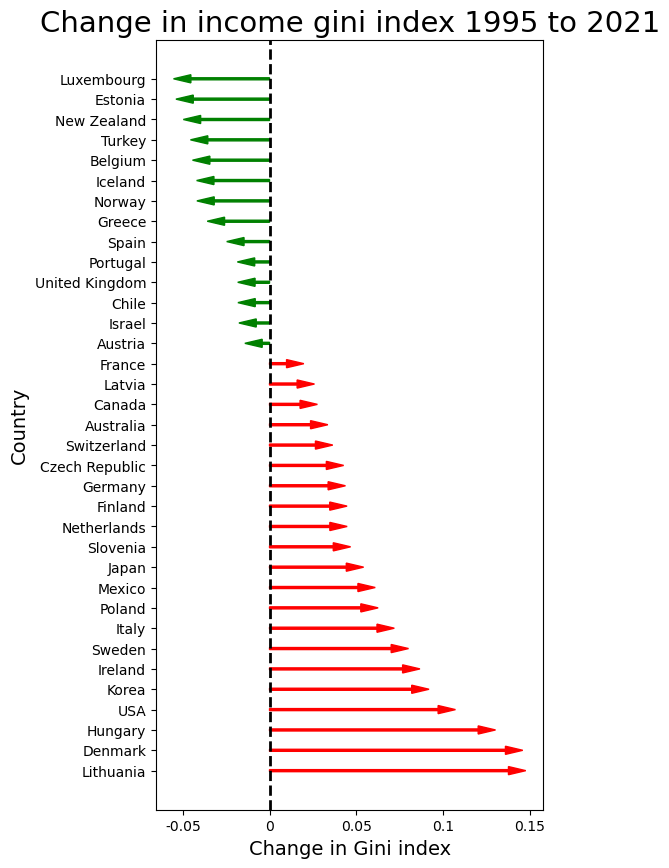

In [37]:
plot_arrow_change(oecd_pretax_gini, 'change', ('pretax_gini_income', 1995), ('pretax_gini_income', 2021), 'country')
plt.title('Change in income gini index 1995 to 2021', fontsize=21)
plt.xlabel('Change in Gini index', fontsize=14) 
plt.ylabel('Country', fontsize=14) 
plt.xticks([-0.05, 0, 0.05, 0.1, 0.15], [-0.05, 0, 0.05, 0.1, 0.15])
plt.show()

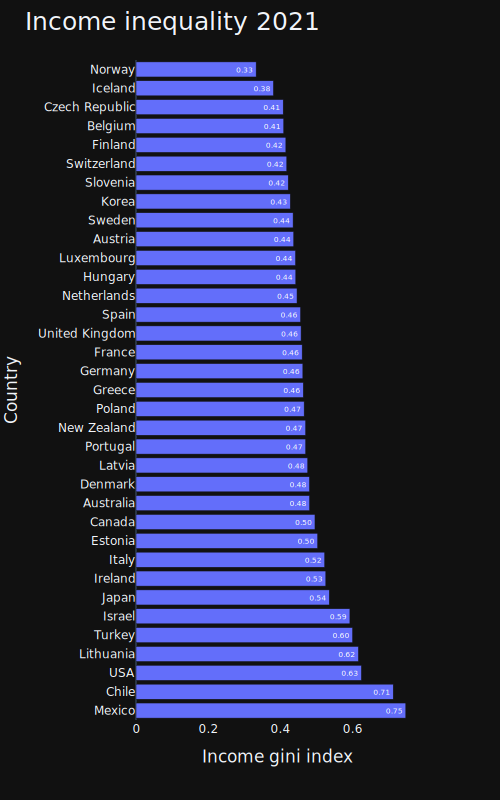

In [192]:
fig = px.bar(oecd.loc[oecd.Year==2021].sort_values('pretax_gini_income', ascending=False), x='pretax_gini_income', 
             y='country', text_auto = '.2f')
fig.update_layout(width=500, height=800,template='plotly_dark',
                  title=dict(text='Income inequality 2021', font=dict(size=25)),
                  xaxis_title=dict(text='Income gini index', font=dict(size=17)),
                  yaxis = dict(tickfont = dict(size=12)),
                  yaxis_title=dict(text='Country', font=dict(size=17)),
                  xaxis = dict(tickfont = dict(size=12)))
fig.update_xaxes(showgrid=False)
fig.show('svg')

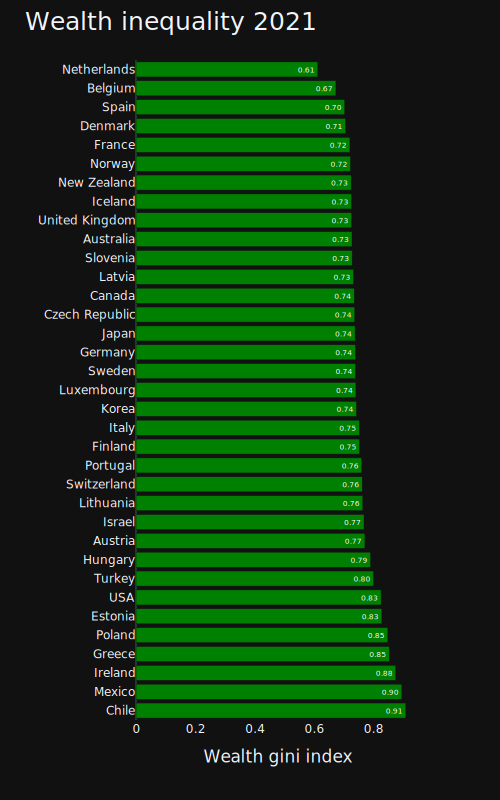

In [193]:
fig = px.bar(oecd.loc[oecd.Year==2021].sort_values('gini_wealth', ascending=False), x='gini_wealth', y='country', 
             text_auto = '.2f')
fig.update_traces(marker=dict(color='green'))
fig.update_layout(width=500, height=800,template='plotly_dark',
                  title=dict(text='Wealth inequality 2021', font=dict(size=25)),
                  xaxis_title=dict(text='Wealth gini index', font=dict(size=17)),
                  yaxis = dict(tickfont = dict(size=12)),
                  yaxis_title=dict(text='', font=dict(size=17)),
                  xaxis = dict(tickfont = dict(size=12)))
fig.update_xaxes(showgrid=False)
#fig.update_yaxes(showticklabels=False) # Hide y axis ticks
fig.show('svg')

***

# Top 10 highest GDP<a id='gdp'><a>

In [40]:
top_gdp_country = ['USA', 'Mexico', 'Germany', 'Japan', 'India', 'United Kingdom', 'France', 'Italy', 'Brazil', 'Canada', 
                   'China', 'Russian Federation']

In [41]:
total_gdp = prepdata('WID_Data_GDP', 'GDP')

In [42]:
total_gdp

Year             country           GDP
0   2021              Brazil  4.001323e+12
1   2021              Canada  2.118742e+12
2   2021               China  3.632427e+13
3   2021              France  3.505248e+12
4   2021             Germany  5.011450e+12
5   2021               India  1.144179e+13
6   2021               Italy  2.816605e+12
7   2021               Japan  5.773555e+12
8   2021              Mexico  2.869456e+12
9   2021  Russian Federation  4.754251e+12
10  2021      United Kingdom  3.120794e+12
11  2021                 USA  2.494836e+13

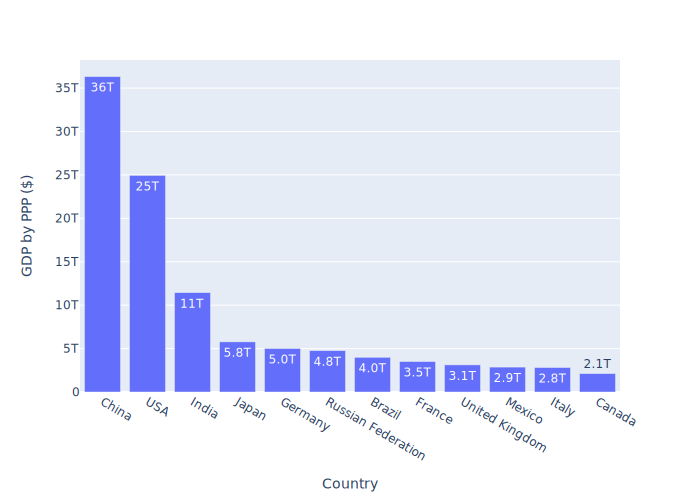

In [43]:
fig = px.bar(total_gdp.sort_values('GDP', ascending=False), x='country', y='GDP', text_auto='.2s')
fig.update_layout(yaxis_title='GDP by PPP ($)',xaxis_title='Country', template='plotly')
fig.show('svg')

In [44]:
gdp = data.loc[(data.country.isin(top_gdp_country))]

In [45]:
fig = px.scatter(gdp, x="pretax_gini_income", y="gini_wealth", animation_frame="Year", size='pretax_mean_income'
                 , hover_name="country", text='country',title='Wealth and Income inequality'
                ,color="country",range_x=[0.4,0.8], range_y=[0.6,0.95])
fig.update_traces(textposition='top center', textfont_size=9, selector=dict(type='scatter'))
fig.update_layout(showlegend=False, yaxis_title='Wealth gini',xaxis_title='Income gini', template='plotly_white')
fig.show()

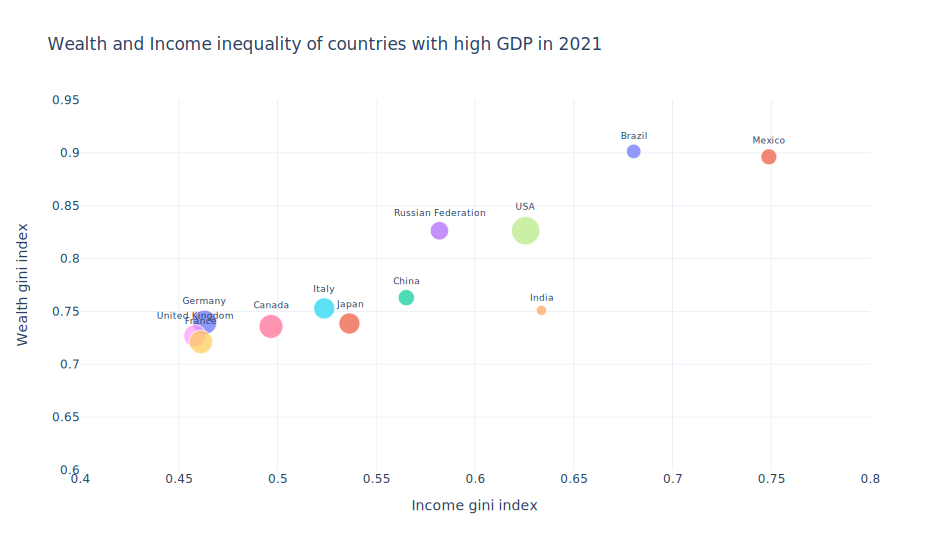

In [46]:
fig = px.scatter(gdp.query('Year==2021'), x="pretax_gini_income", y="gini_wealth", size='pretax_mean_income'
                 , hover_name="country", text='country',title='Wealth and Income inequality of countries with high GDP in 2021'
                ,color="country",range_x=[0.4,0.8], range_y=[0.6,0.95])
fig.update_traces(textposition='top center', textfont_size=9, selector=dict(type='scatter'))
fig.update_layout(showlegend=False, yaxis_title='Wealth gini index',xaxis_title='Income gini index', 
                  template='plotly_white', width=950, height=550)
fig.show('svg')

Inequality in US is worse than other developed countries.

In [47]:
gdp_pretax_gini = gdp.loc[(gdp.Year==1995) | (gdp.Year==2021), ['Year', 'country','pretax_gini_income']]
gdp_pretax_gini = gdp_pretax_gini.pivot(index='country', columns='Year').reset_index()
gdp_pretax_gini['change'] = gdp_pretax_gini.pretax_gini_income[2021]-gdp_pretax_gini.pretax_gini_income[1995]

In [48]:
gdp_wealth_gini = gdp.loc[(gdp.Year==1995) | (gdp.Year==2021), ['Year', 'country','gini_wealth']]
gdp_wealth_gini = gdp_wealth_gini.pivot(index='country', columns='Year').reset_index()
gdp_wealth_gini['change'] = gdp_wealth_gini.gini_wealth[2021]-gdp_wealth_gini.gini_wealth[1995]

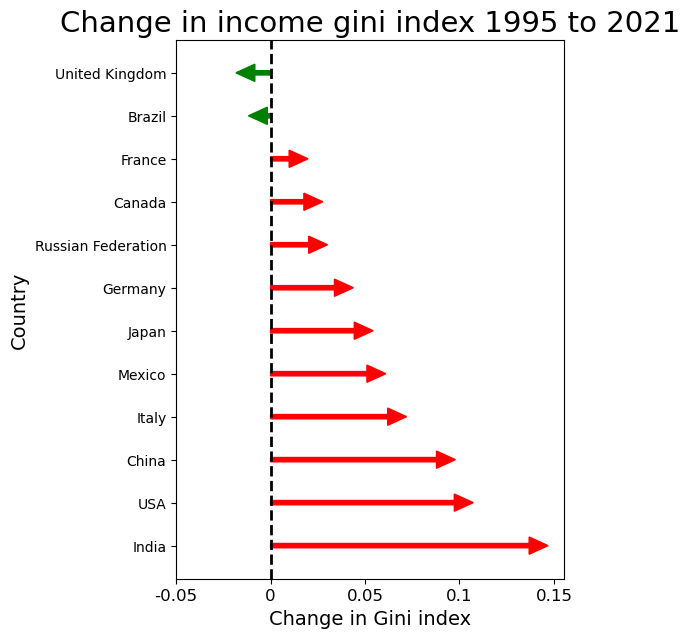

In [49]:
plot_arrow_change(gdp_pretax_gini, 'change', ('pretax_gini_income', 1995), ('pretax_gini_income', 2021), 'country', (5,7))
plt.title('Change in income gini index 1995 to 2021', fontsize=21)
plt.xlabel('Change in Gini index', fontsize=14) 
plt.ylabel('Country', fontsize=14) 
plt.xticks([-0.05, 0, 0.05, 0.1, 0.15], [-0.05, 0, 0.05, 0.1, 0.15], fontsize=12)
plt.show()

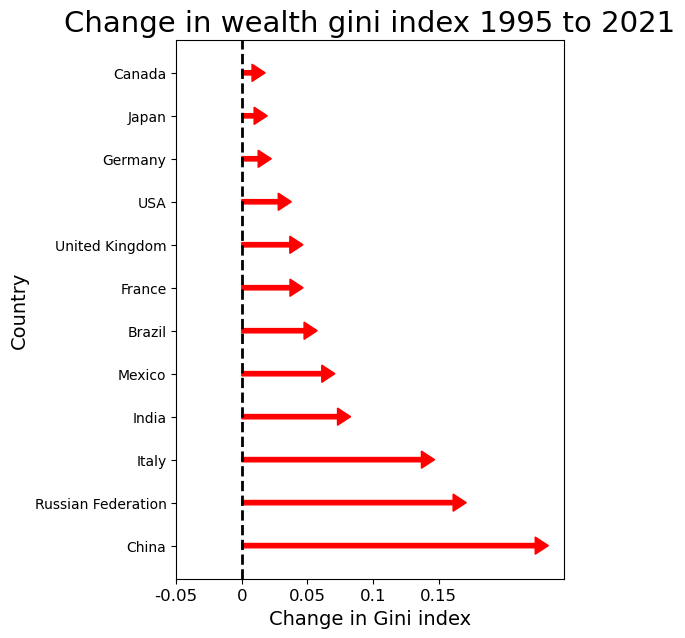

In [50]:
plot_arrow_change(gdp_wealth_gini, 'change', ('gini_wealth', 1995), ('gini_wealth', 2021), 'country', (5,7))
plt.title('Change in wealth gini index 1995 to 2021', fontsize=21)
plt.xlabel('Change in Gini index', fontsize=14) 
plt.ylabel('Country', fontsize=14) 
plt.xticks([-0.05, 0, 0.05, 0.1, 0.15], [-0.05, 0, 0.05, 0.1, 0.15], fontsize=12)
plt.show()

***

# G7<a id='g7'><a>

In [54]:
g7_top10_income = prepdata('WID_Data_Top10_income', 'top10_income')

In [55]:
g7_top10_wealth = prepdata('WID_Data_Top10_wealth', 'top10_wealth')

In [56]:
g7_top1_income = prepdata('WID_Data_Top1_income', 'top1_income')
g7_top1_wealth = prepdata('WID_Data_Top1_wealth', 'top1_wealth')
g7_bottom50_income = prepdata('WID_Data_Bottom50_income', 'bottom50_income')
g7_bottom50_wealth = prepdata('WID_Data_Bottom50_wealth', 'bottom50_wealth')

In [57]:
g7_top10 = g7_top10_income.merge(g7_top10_wealth, on=['Year', 'country'])

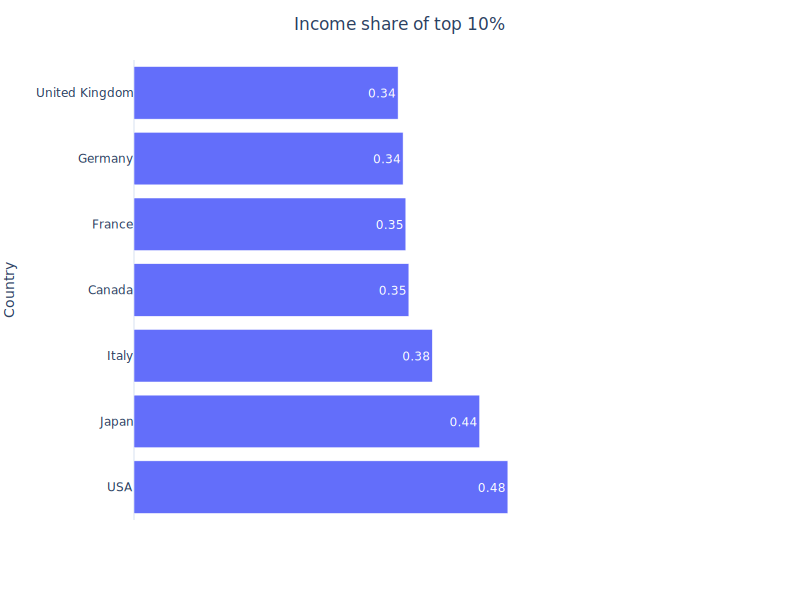

In [210]:
fig = px.bar(g7_top10.query('Year==2021').sort_values('top10_income', ascending=False), x='top10_income', 
             y='country', text_auto='.2', range_x=[0,0.75])
fig.update_layout(yaxis_title='Country',xaxis_title='', template='plotly_white', 
                  title={'text': "Income share of top 10%", 'x':0.5}, width=800, height=600)
fig.update_xaxes(showgrid=False)
fig.update_xaxes(showticklabels=False)
fig.show('svg')

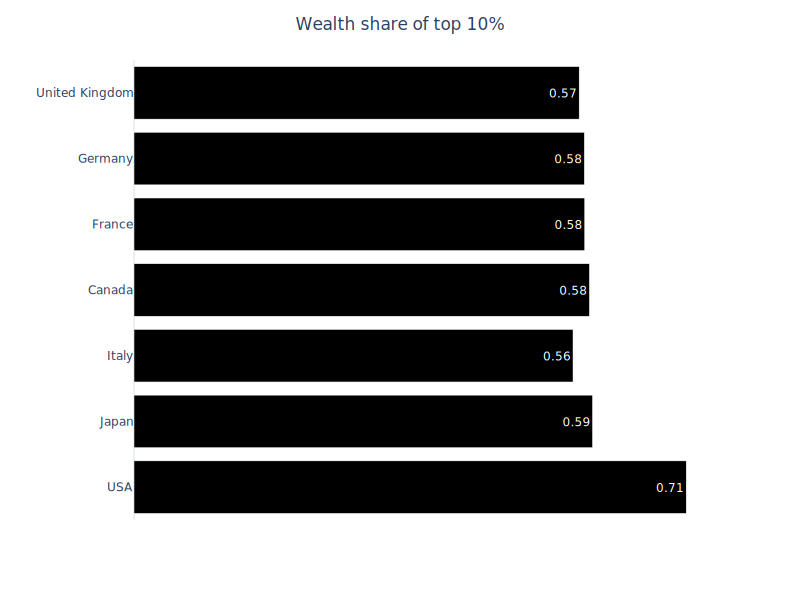

In [211]:
fig = px.bar(g7_top10.query('Year==2021').sort_values('top10_income', ascending=False), x='top10_wealth', 
             y='country', text_auto='.2', range_x=[0,0.75])
fig.update_traces(marker=dict(color='black'))
fig.update_layout(yaxis_title='',xaxis_title='', template='plotly_white', 
                  title={'text': "Wealth share of top 10%", 'x':0.5}, width=800, height=600)
fig.update_xaxes(showgrid=False)
fig.update_xaxes(showticklabels=False)
#fig.update_yaxes(showticklabels=False)
fig.show('svg')

In [60]:
us_top1_income = g7_top1_income.query('country=="USA"')
us_bottom50_income = g7_bottom50_income.query('country=="USA"')
us_top1_wealth = g7_top1_wealth.query('country=="USA"')
us_bottom50_wealth = g7_bottom50_wealth.query('country=="USA"')

In [61]:
g7_avg_top1_income = g7_top1_income.groupby('Year', as_index=False).top1_income.mean()
g7_avg_bottom50_income = g7_bottom50_income.groupby('Year', as_index=False).bottom50_income.mean()
g7_avg_top1_wealth = g7_top1_wealth.groupby('Year', as_index=False).top1_wealth.mean()
g7_avg_bottom50_wealth = g7_bottom50_wealth.groupby('Year', as_index=False).bottom50_wealth.mean()

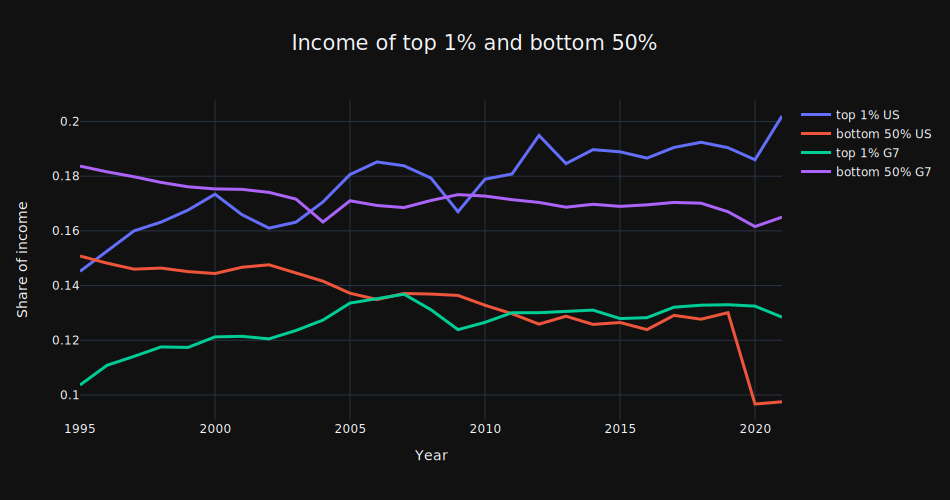

In [215]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=us_top1_income.Year, y=us_top1_income.top1_income, line={'width': 3}, name='top 1% US'))
fig.add_trace(go.Scatter(x=us_bottom50_income.Year, y=us_bottom50_income.bottom50_income, line={'width': 3}, name='bottom 50% US'))
fig.add_trace(go.Scatter(x=g7_avg_top1_income.Year, y=g7_avg_top1_income.top1_income, line={'width': 3}, name='top 1% G7'))
fig.add_trace(go.Scatter(x=g7_avg_top1_income.Year, y=g7_avg_bottom50_income.bottom50_income, line={'width': 3}, name='bottom 50% G7'))
fig.update_layout(yaxis_title={'text':'Share of income'},
                  xaxis_title='Year', 
                  #yaxis = dict(tickfont = dict(size=12)),
                  #yaxis_title=dict(text='', font=dict(size=17))
                  template='plotly_dark', 
                  title={'text': "Income of top 1% and bottom 50%", 'x':0.5, 'font':{'size':21}},
                 width=950, height=500)
#fig.update_xaxes(showgrid=False)
#fig.update_yaxes(showgrid=False)
fig.show('svg')

Top 1% of US has more share than bottom 50%.

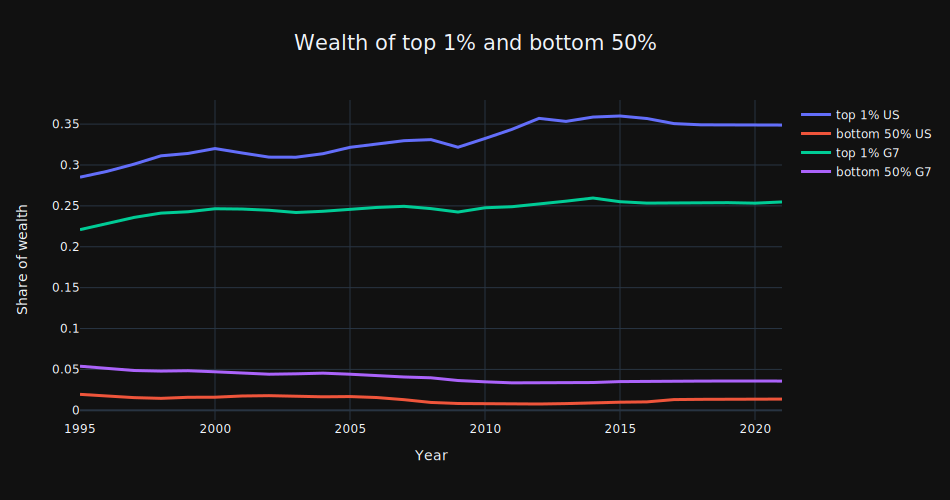

In [216]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=us_top1_wealth.Year, y=us_top1_wealth.top1_wealth, line={'width': 3}, name='top 1% US'))
fig.add_trace(go.Scatter(x=us_bottom50_wealth.Year, y=us_bottom50_wealth.bottom50_wealth, line={'width': 3}, name='bottom 50% US'))
fig.add_trace(go.Scatter(x=g7_avg_top1_wealth.Year, y=g7_avg_top1_wealth.top1_wealth, line={'width': 3}, name='top 1% G7'))
fig.add_trace(go.Scatter(x=g7_avg_top1_wealth.Year, y=g7_avg_bottom50_wealth.bottom50_wealth, line={'width': 3}, name='bottom 50% G7'))
fig.update_layout(yaxis_title={'text':'Share of wealth'},
                  xaxis_title='Year', 
                  #yaxis = dict(tickfont = dict(size=12)),
                  #yaxis_title=dict(text='', font=dict(size=17))
                  template='plotly_dark', 
                  title={'text': "Wealth of top 1% and bottom 50%", 'x':0.5, 'font':{'size':21}},
                 width=950, height=500)
#fig.update_xaxes(showgrid=False)
#fig.update_yaxes(showgrid=False)
fig.show('svg')

The wealth gap in the US is larger than that of G7.

In [64]:
g7_countries = ['United States', 'Germany', 'Japan', 'United Kingdom', 'France', 'Italy', 'Canada'] 

In [180]:
world_trade = 100*(world.trade/world.trade.min()-1)
g7_avg_top1_income_rel = 100*(g7_avg_top1_income.top1_income/g7_avg_top1_income.top1_income.min()-1)
us_top1_income_rel = 100*(us_top1_income.top1_income/us_top1_income.top1_income.min()-1)

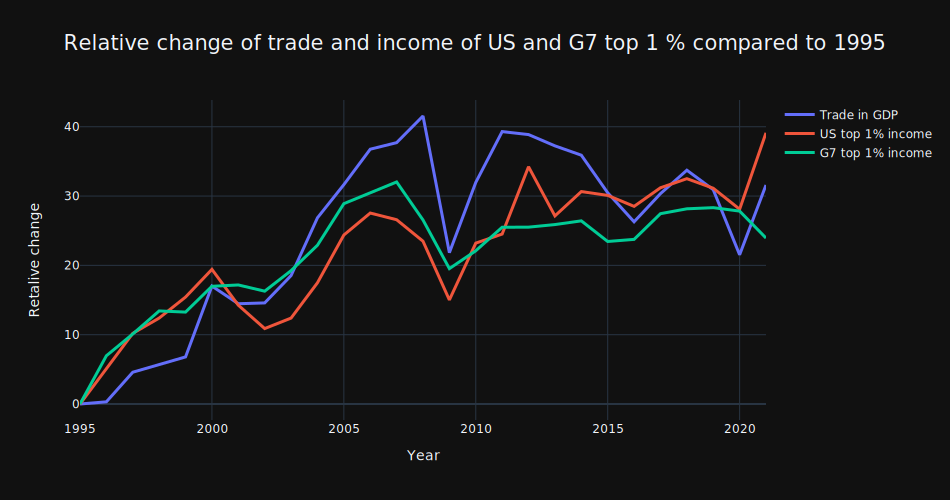

In [181]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=np.arange(1995, 2022), y=world_trade, line={'width': 3}, name='Trade in GDP'))
fig.add_trace(go.Scatter(x=np.arange(1995, 2022), y=us_top1_income_rel, line={'width': 3}, name='US top 1% income'))
fig.add_trace(go.Scatter(x=np.arange(1995, 2022), y=g7_avg_top1_income_rel, line={'width': 3}, name='G7 top 1% income'))
fig.update_layout(yaxis_title={'text':'Retalive change'},
                  xaxis_title='Year', 
                  template='plotly_dark', 
                  title={'text': "Relative change of trade and income of US and G7 top 1 % compared to 1995", 
                         'x':0.5, 'font':{'size':21}}, width=950, height=500)

fig.show('svg')

The relative change of top 1% income has the same trend as trade. 

# Tax

In [73]:
tax = pd.read_csv('../data/raw/Tax.csv')
tax = tax.loc[tax.Country.isin(g7_countries)]
tax_rate = tax.loc[tax['Income Tax']=='Top tax rates']
tax_rate.query('Year==2022')

COU         Country        TAX     Income Tax   YEA  Year Unit Code  \
574   GBR  United Kingdom  TOP_TRATE  Top tax rates  2022  2022        PC   
827   JPN           Japan  TOP_TRATE  Top tax rates  2022  2022        PC   
1540  ITA           Italy  TOP_TRATE  Top tax rates  2022  2022        PC   
3035  DEU         Germany  TOP_TRATE  Top tax rates  2022  2022        PC   
3334  CAN          Canada  TOP_TRATE  Top tax rates  2022  2022        PC   
3518  USA   United States  TOP_TRATE  Top tax rates  2022  2022        PC   
3840  FRA          France  TOP_TRATE  Top tax rates  2022  2022        PC   

            Unit  PowerCode Code PowerCode  Reference Period Code  \
574   Percentage               0     Units                    NaN   
827   Percentage               0     Units                    NaN   
1540  Percentage               0     Units                    NaN   
3035  Percentage               0     Units                    NaN   
3334  Percentage               0     Units                    NaN   
3518  Percentage               0     Units                    NaN   
3840  Percentage               0     Units                    NaN   

      Reference Period    Value  Flag Codes  Flags  
574                NaN  45.0000         NaN    NaN  
827                NaN  55.9450         NaN    NaN  
1540               NaN  47.2300         NaN    NaN  
3035               NaN  47.4750         NaN    NaN  
3334               NaN  53.5296         NaN    NaN  
3518               NaN  43.6500         NaN    NaN  
3840               NaN  55.3680         NaN    NaN

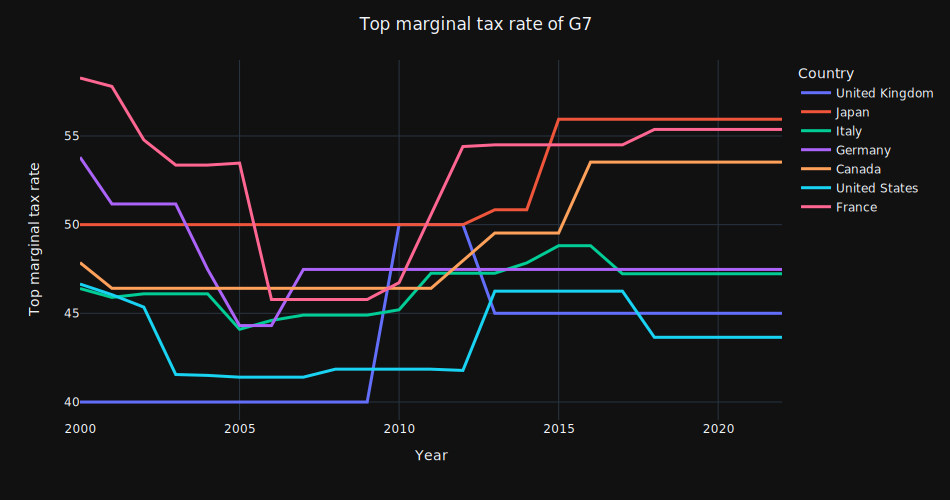

In [74]:
fig = px.line(tax_rate, x='Year', y='Value', color='Country')
fig.update_traces(line={'width': 3})
fig.update_layout(yaxis_title='Top marginal tax rate',xaxis_title='Year', template='plotly_dark', 
                  title={'text': "Top marginal tax rate of G7", 'x':0.5}, width=950, height=500)
fig.show('svg')

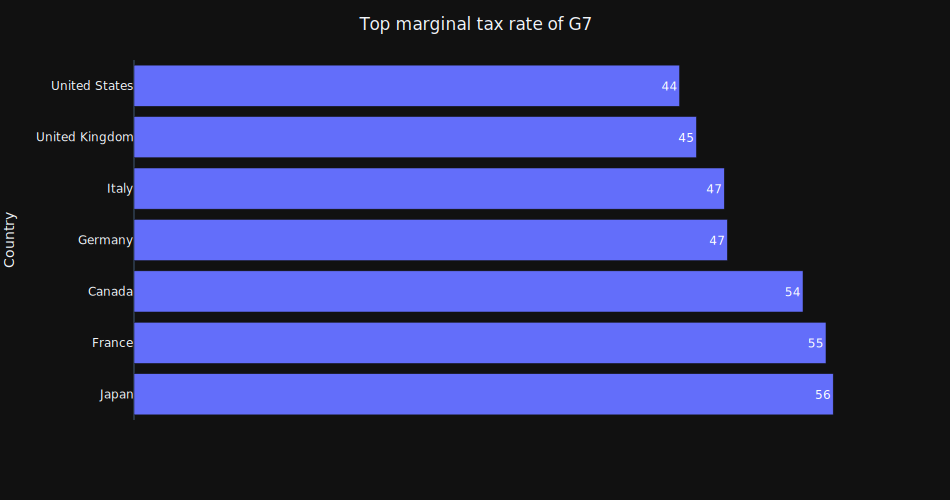

In [75]:
fig = px.bar(tax_rate.query('Year==2022').sort_values('Value', ascending=False), x='Value', 
             y='Country', text_auto='.2')
fig.update_layout(yaxis_title='Country',xaxis_title='', template='plotly_dark', 
                  title={'text': "Top marginal tax rate of G7", 'x':0.5}, width=950, height=500)
fig.update_xaxes(showgrid=False)
fig.update_xaxes(showticklabels=False)
fig.show('svg')

Top marginal tax of US is the lowest in G7, which maybe the reason of larger inequality.

# Wage

In [104]:
wage = pd.read_csv('../data/raw/Min_wage.csv')

In [105]:
wage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2728 entries, 0 to 2727
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   STRUCTURE              2728 non-null   object 
 1   STRUCTURE_ID           2728 non-null   object 
 2   STRUCTURE_NAME         2728 non-null   object 
 3   ACTION                 2728 non-null   object 
 4   REF_AREA               2728 non-null   object 
 5   Reference area         2728 non-null   object 
 6   MEASURE                2728 non-null   object 
 7   Measure                2728 non-null   object 
 8   UNIT_MEASURE           2728 non-null   object 
 9   Unit of measure        2728 non-null   object 
 10  PAY_PERIOD             2728 non-null   object 
 11  Pay period             2728 non-null   object 
 12  PRICE_BASE             2728 non-null   object 
 13  Price base             2728 non-null   object 
 14  AGGREGATION_OPERATION  2728 non-null   object 
 15  Aggr

In [106]:
wage = wage.loc[wage.UNIT_MEASURE=='USD_PPP'][['Reference area', 'TIME_PERIOD', 'OBS_VALUE']].\
rename(columns={'Reference area':'country', 'TIME_PERIOD':'year','OBS_VALUE':'wage'})
wage

country  year          wage
28      Japan  1977   7756.131773
29      Japan  1978   8143.474657
30      Japan  1979   8539.047941
31      Japan  1980   8423.835572
32      Japan  1981   8529.971646
...       ...   ...           ...
2698  Romania  2018  13908.790176
2699  Romania  2019  14653.448736
2700  Romania  2020  15352.460591
2701  Romania  2021  15210.402183
2702  Romania  2022  15053.987732

[1364 rows x 3 columns]

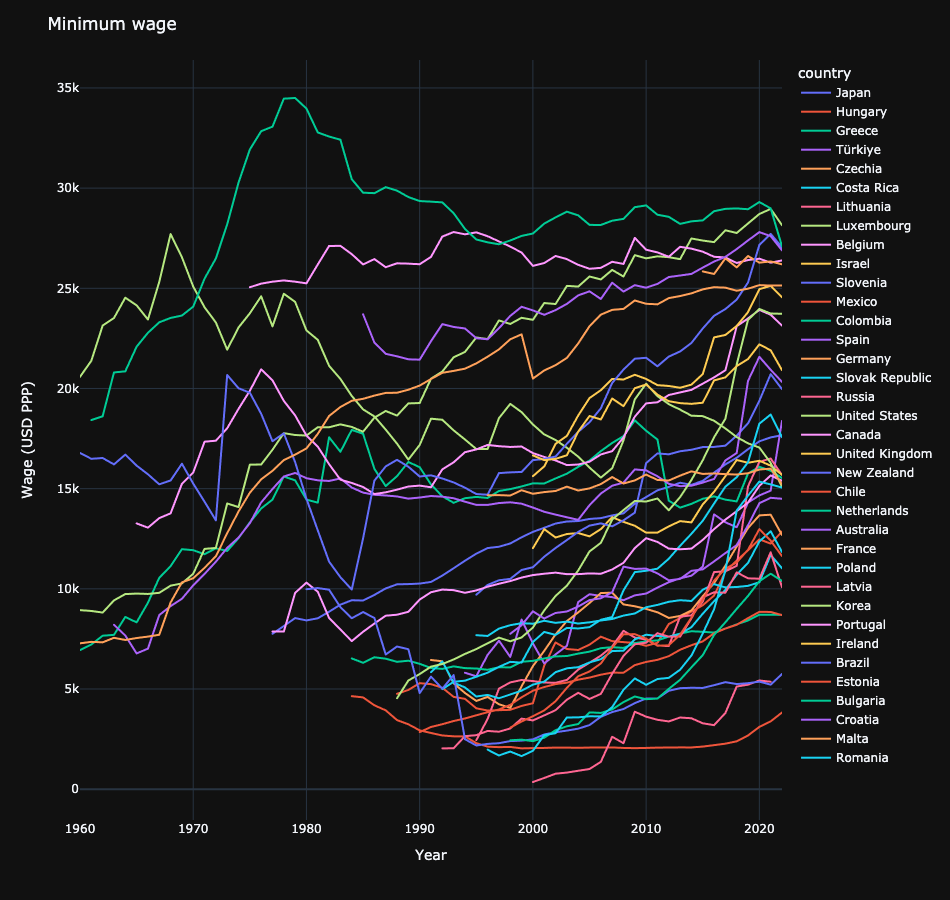

In [217]:
fig = px.line(wage, x='year', y='wage', color='country')
fig.update_xaxes(title='Year')
fig.update_yaxes(title='Wage (USD PPP)')
fig.update_layout(title='Minimum wage',template='plotly_dark', width=950, height=900)
fig.show('png')

In [117]:
g7_wage = wage.loc[wage.country.isin(g7_countries)]

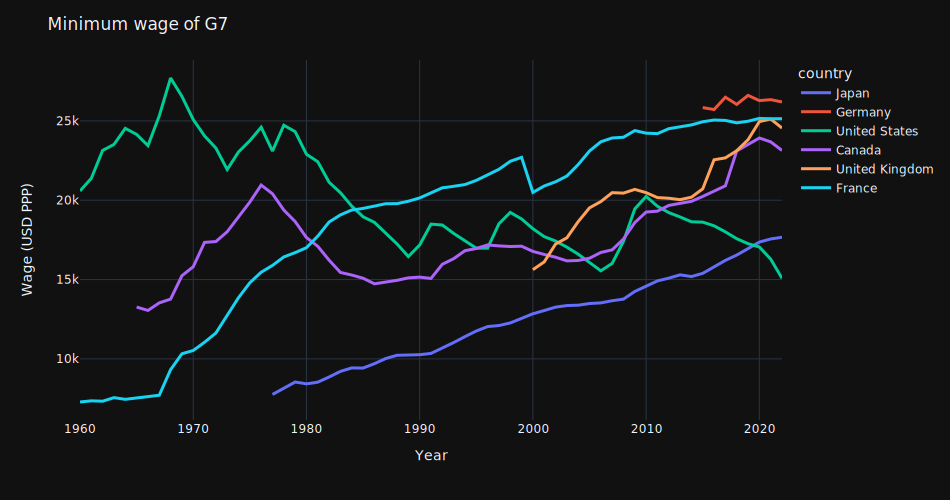

In [122]:
fig = px.line(g7_wage, x='year', y='wage', color='country')
fig.update_traces(line={'width':3})
fig.update_xaxes(title='Year')
fig.update_yaxes(title='Wage (USD PPP)')
fig.update_layout(title='Minimum wage of G7',template='plotly_dark', width=950, height=500)
fig.show('svg')

While there is no data of Italy and very small amount of data point on Germany's minimum wage, it can be seen that the US minimum wage is in decline.

In [121]:
g7_wage.query('country=="United Kingdom"').year.min()

2000

Calculate relative change compared to year 2000

In [171]:
g7_wage_2000 = g7_wage.query('country!="Germany" & year>=2000')

In [175]:
g7_wage_2000 = g7_wage_2000.assign(rel_change=
                                   g7_wage_2000.groupby(['country'])['wage'].transform(lambda x: 100*(x/x.iloc[0]-1)))

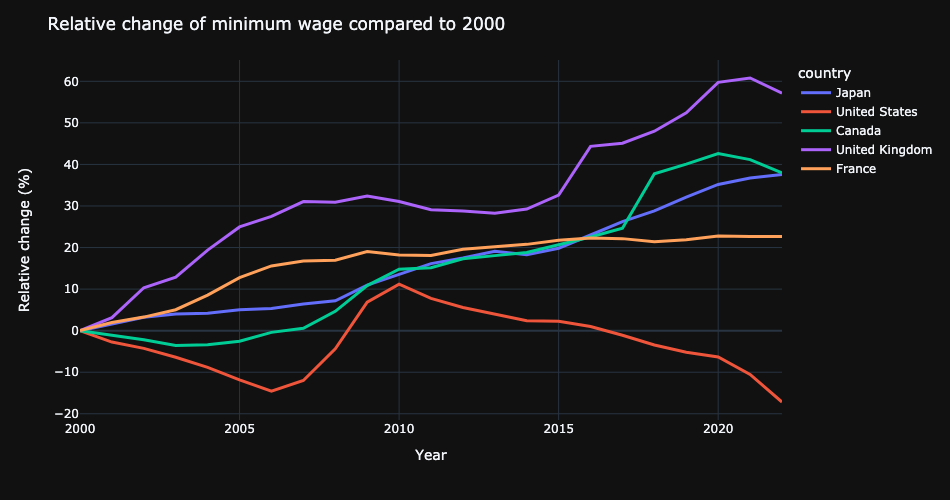

In [219]:
fig = px.line(g7_wage_2000, x='year', y='rel_change', color='country')
fig.update_traces(line={'width':3})
fig.update_xaxes(title='Year')
fig.update_yaxes(title='Relative change (%)')
fig.update_layout(title='Relative change of minimum wage compared to 2000',template='plotly_dark', width=950, height=500)
fig.show('png')

Calculate relative change compared to year 2015

In [188]:
g7_wage_2015 = g7_wage.query('year>=2015')

In [189]:
g7_wage_2015 = g7_wage_2015.assign(rel_change=
                                   g7_wage_2015.groupby(['country'])['wage'].transform(lambda x: 100*(x/x.iloc[0]-1)))

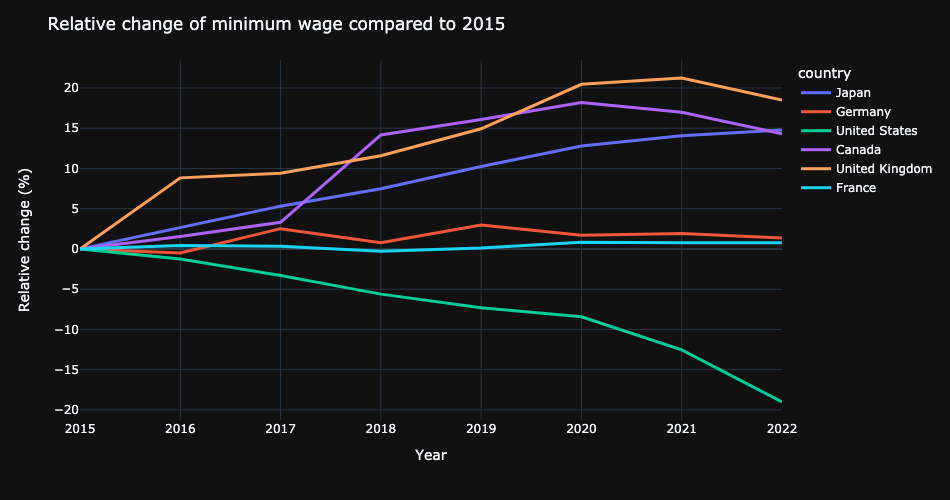

In [218]:
fig = px.line(g7_wage_2015, x='year', y='rel_change', color='country')
fig.update_traces(line={'width':3})
fig.update_xaxes(title='Year')
fig.update_yaxes(title='Relative change (%)')
fig.update_layout(title='Relative change of minimum wage compared to 2015',template='plotly_dark', width=950, height=500)
fig.show('png')

Minimum wage in the US is in decline while the other G7 is not.